# <font color='Grey'>Table of contents<font><a id='top'></a>
- [Prompt](#0)
- [Understanding the Business Goals](#1)
    - [Clarifying The Main Goal](#1-1)
    - [Key Assumptions](#1-2)
    - [Constraints](#1-3)
    - [Key Performance Indicators](#1-4)
    - [Understanding The Data](#1-5)
    - [How do We Accomplish This?](#1-6)
- [Generating Synthetic Data](#2)
- [Optimization Algorithm](#3)
- [Portfolio Strategies](#4)
    - [Maxmize Sales](#4-1)
    - [Maxmize Margin](#4-2)
    - [Revenue/Margin Blend](#4-3)
    - [Low Volatility](#4-4)
    - [High Growth](#4-5)
- [Hitting a goal in one feature while maximizing another](#5)
    - [Sales Target While Maximizing Margins](#5-1)
    - [Margin Target While Maximizing Sales](#5-2)
- [5 year forecasting using stochastic processes](#6)
- [Experimenting with different Macroeconomic Trends](#7)
    - [Recession](#7-1)
    - [High Growth](#7-2)
- [Thoughts & Reflections](#8)


## Prompt <a class='anchor' id='0'></a>


### Directions

In [1]:
from IPython.display import IFrame, display
display(IFrame("Case_Study.pdf", width=800, height=600))

### Organization Chart

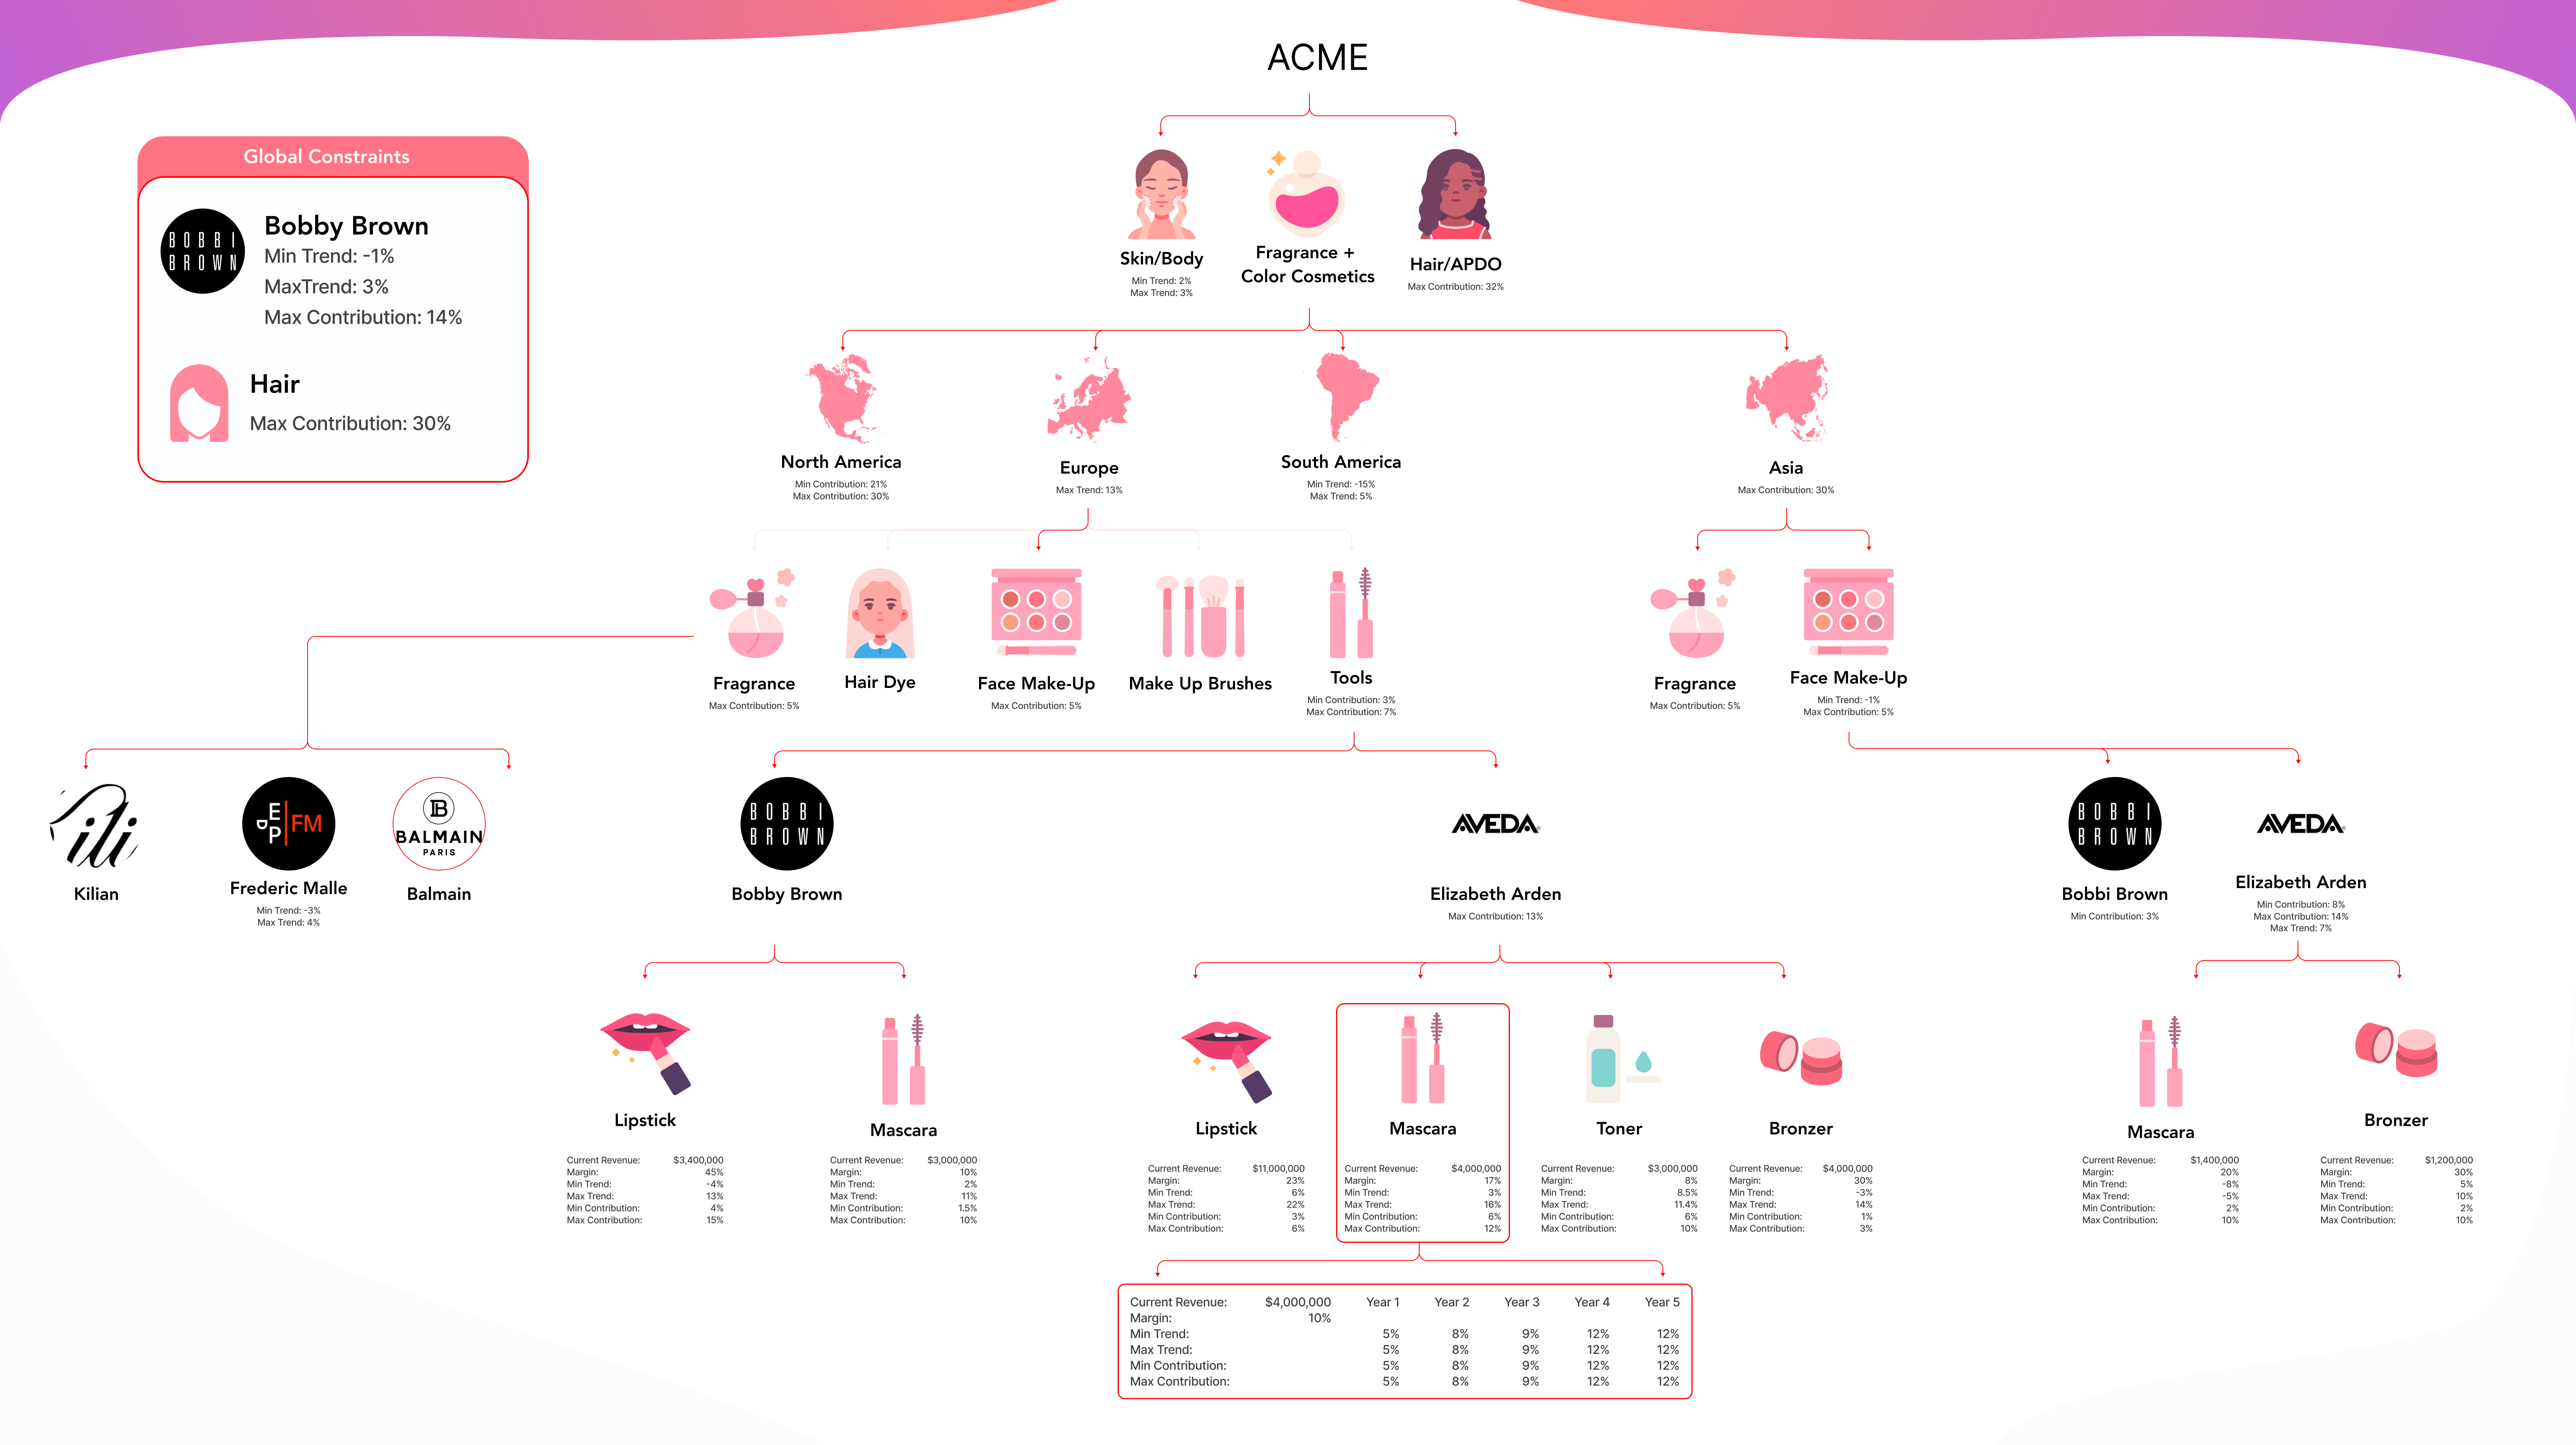

In [2]:
from IPython.display import Image
img = Image("docs/Acme_Org_Chart.png", width=1200, height=600)
img

## Understanding The Business Goals <a id='1'></a>




### What is the Main Goal? <a id='1-1'></a>

This problem is very similar to managing a portfolio of stocks, In that the main goal is to determine the optimal portfolio blend for each sub-company within Acme algorithmically by:

- Optimizing Key Performance Indicators (KPIs)
    - Balancing metrics like total sales, profit margins, and growth trends to maximize overall performance.
- Accounting for Trends and Constraints:
    - Factoring in predicted market trends and operational constraints (like contribution ratios that must sum to 100% at the segment level) to simulate realistic scenarios and outcomes.
- Scenario-Based Decision Making:
    - Creating multiple forecasting scenarios that can help assess different strategies and risks, ultimately guiding the optimal portfolio mix for different macroeconomic enviroments.




### Key Assumptions <a id='1-2'></a>


Given the limited details of the organization chart we are going to have to make some important assumptions that will dictate how this problem is approached.

- Minimum and Maximum trend constraints are fixed within the 5 year time frame and are not fluctuating due to outside Macroeconomic factors
- Trends are log normlly distributed with a mean in the average of the minum and maximum trend and therefore can be modeled using a monte carlo simulation. 
- There is no cost to changing the contribution amount for each segment 
- Each segment is independent and the trends of similar categories do not correlate
- The sum of every max contribution % is less than 100 therefore I am scaling the data to correct this 
    - Addressing Global constraints before normalization
- Trends propagate down the org chart, (i.e. if europe as a whole is trending then the products within europe will also account for this)
    - This also means that the revenue is propagated upward to represent totals
- Removing Units that do not have enough data to influence any decision making, such as the fragrance category in Europe which provides no information that is helpful when optimizing the porfolio

### Constraints <a id='1-3'></a>

What are the main limitations?

- Companies have minimum and maximum contribution amounts 
- hierarchal structure, The constraints of entities higher in the chart affect the descendents

### Key Performance Indicators <a id='1-4'></a>

What metrics are important and why? 

- Margin
    - Measures the difference between revenue and expenses 
    - "How efficient are we?"

- Sales
    - Measures the total amount of sales
    - "How effective are we?"

- Risk 
    - How much variability is there in the trend

### Understanding The Data<a id='1-5'></a>

| **Term**                     | **Definition**                                                                                                                                                         |
|------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Sales**                    | Total sales for that particular unit (provided as an initial input).                                                                                                   |
| **Margin**                   | Profit for the unit (provided as an initial input) and typically remains constant year-to-year.                                                                        |
| **Trend**                    | The predicted growth Acme expects for the unit, reflecting market trends (can also be negative).                                                                        |
| **Contribution**             | The percentage of the overall portfolio that the unit comprises. At the segment level, all segments within a brand must sum to 1 (100%).                                |
| **New Sales for each Segment** | The output representing new sales generated for each segment after the algorithm is executed.                                                                           |
| **New Contribution**         | The new contribution percentage calculated for a segment, brand, category, etc., as a result of the algorithm's execution.                                               |


### How do we do accomplish our goals?  <a id='1-6'></a>

1. Generate synthetic data for each company that align with the general constraints.
    - Accounting for the hierarchal dynamic 
2. Bottom-Up optimization
    - optimize the blend of contributions of segments for each layer.
3. Simulate stochastic process for forecasting
    - Run simulations for different startegies seeing the results over time 


## Question 1. Generating Synthetic Data<a id='2'></a>

Since the companies have the same attributes using a class allows for all information to be easily contained, Each company will have the attributes 

Name \
Max Contribution \
Min Contribution \
Current Contribution \
Revenue \
Margin Percentage \
Margin Dollars \
Volatility \
Min Trend \
Max Trend \
Sub Units

Given the hierarchical nature of the data, modeling the organization as a tree is a logical choice. This approach offers both advantages and challenges.

The primary advantage is the ability to efficiently track hierarchical trends, making it well-suited for the given data structure and constraints. This feature is particularly valuable in the simulation phase, as it allows for the exploration of various macroeconomic scenarios, such as increased market volatility or recessions.

However, using a tree structure also introduces additional complexity. Traversing and updating the tree requires specialized algorithms, adding to the computational overhead. Additionally, modifying the structure—such as adding or removing companies for testing—becomes more cumbersome compared to simpler data representations such as a dataframe approach.

Imports

In [3]:
from figure_settings.fig_settings import *
from src.hierarchy_tree import HierarchyTree
from src.optimizer import *
from src.unit_class import Unit
from src.forecast_simulation import *
from src.tree_visualization import *
import pandas as pd 
import numpy as np
import copy

Below is the structure of Acme as outlined in the provided PDF, along with additional details on certain companies. These additions highlight specific scenarios, such as low revenue but high growth, high revenue with low margins, and high revenue with significant volatility. These additions are added in the fragrance section of Europe as well as Bobbi Brown in Asia 

/home/jackyeung99/ProMazo_Case_Study/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


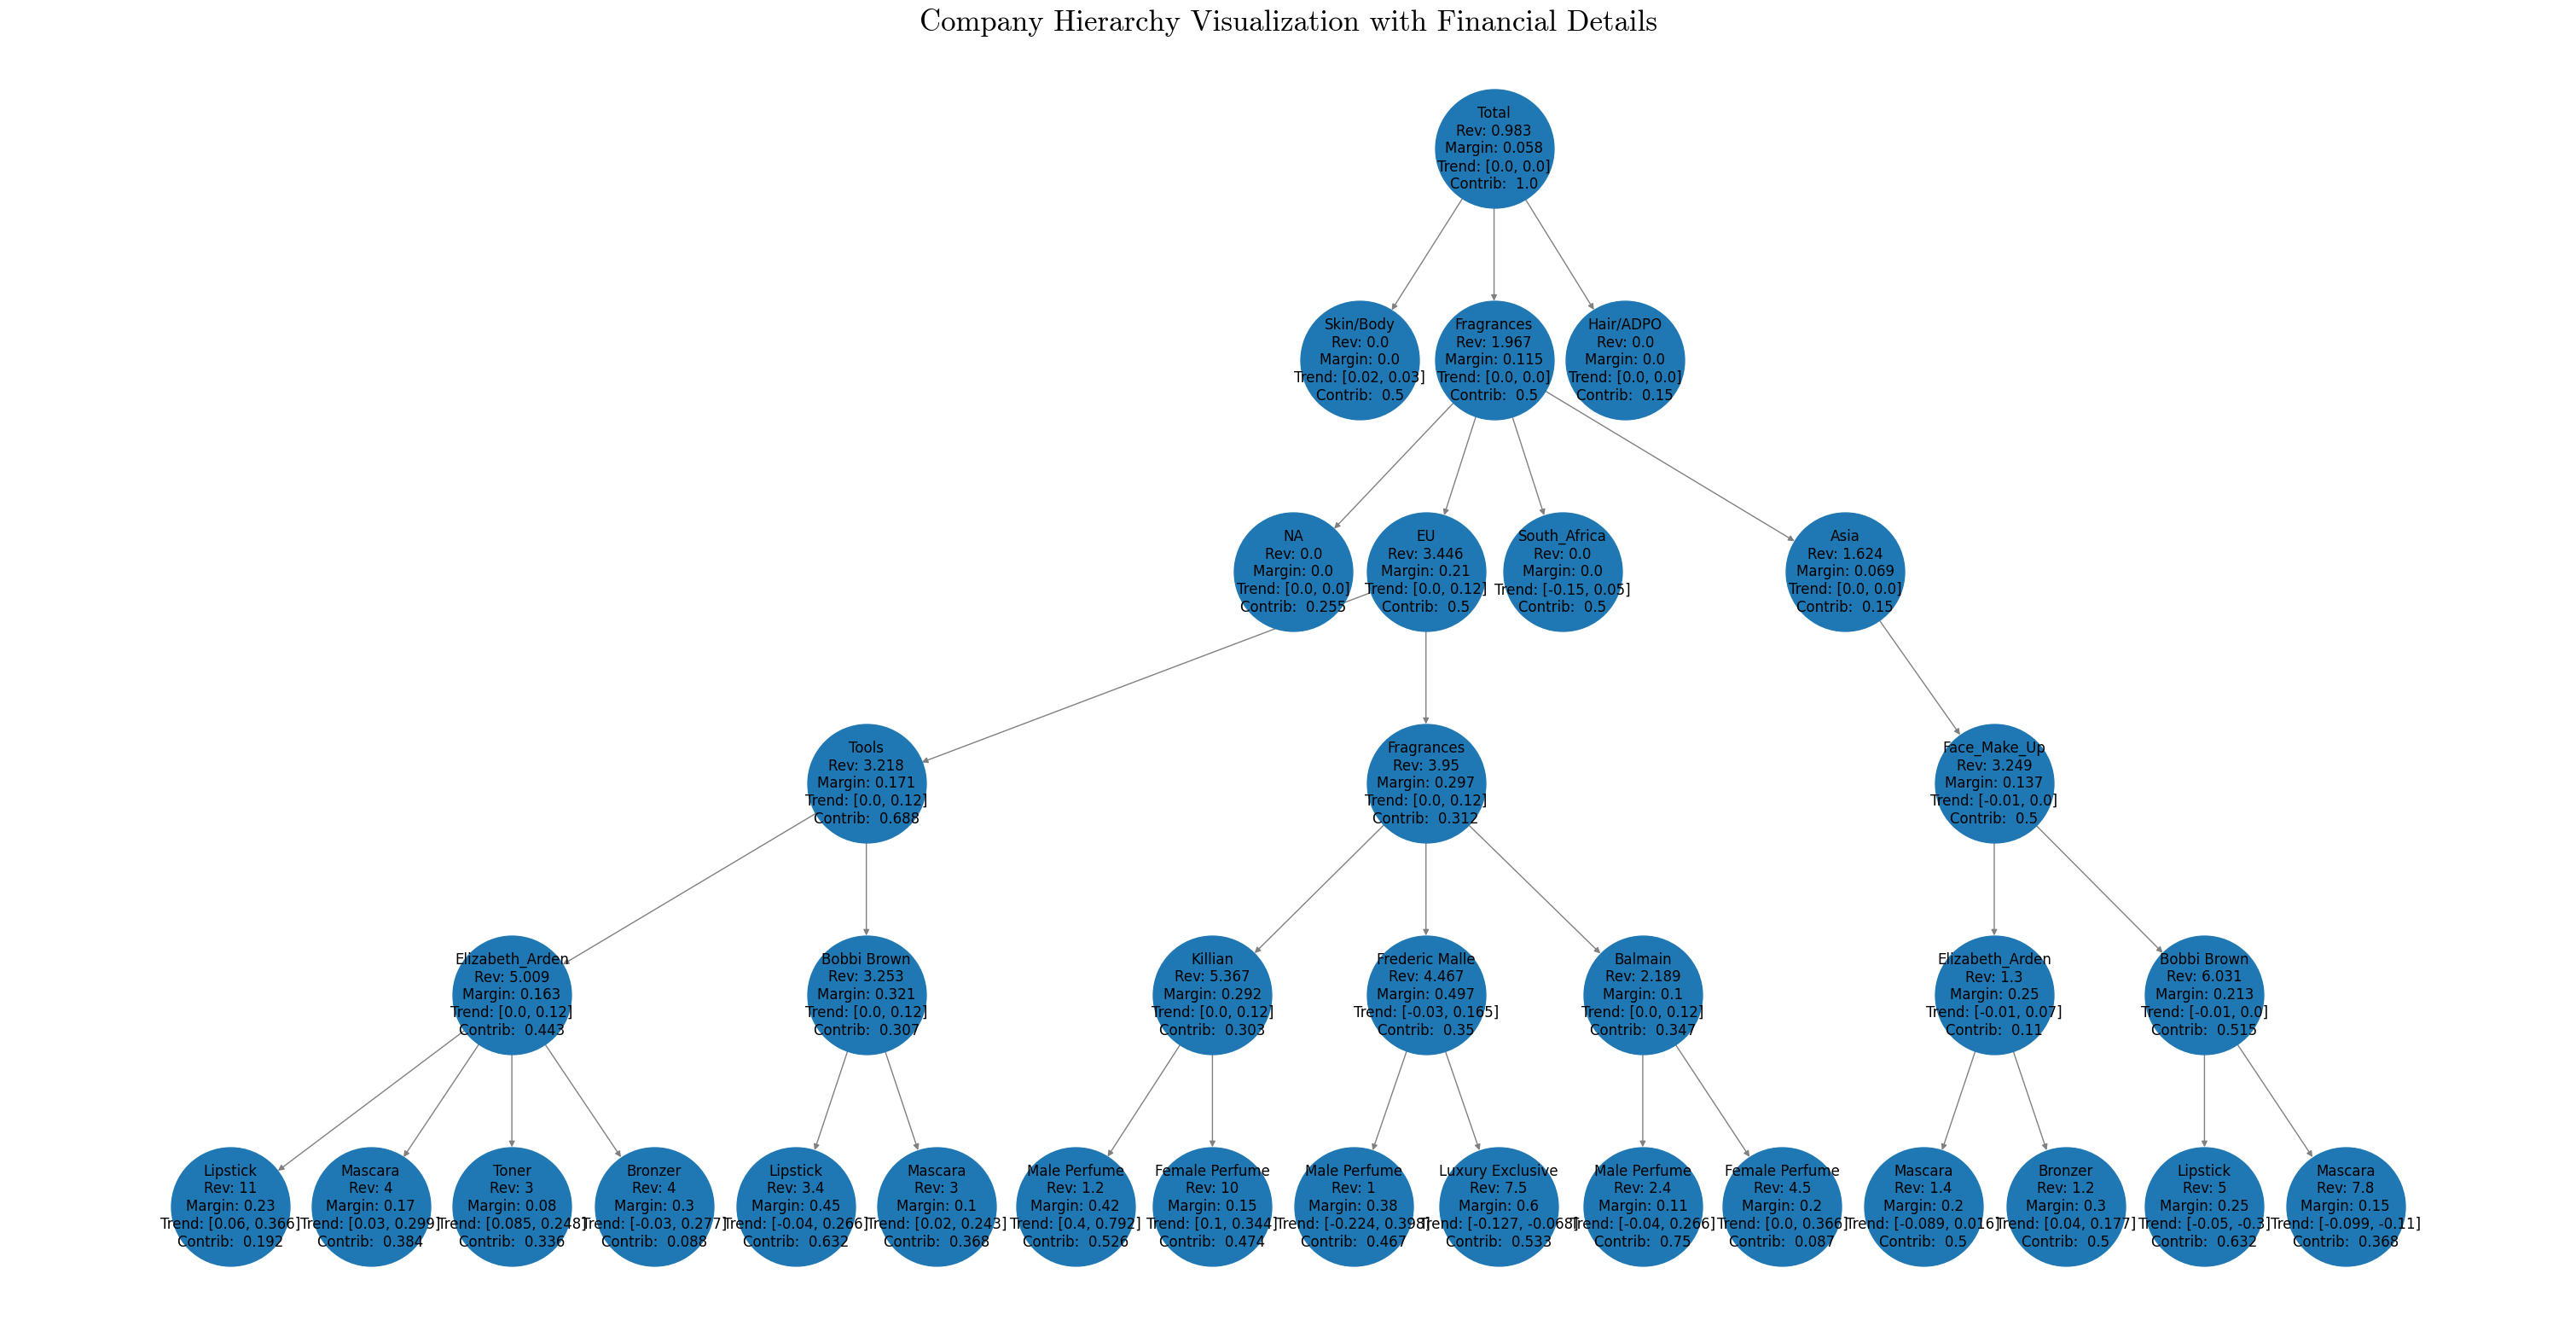

 Level             Name  Total Revenue   Margin  Contribution  Min_Contribution  Max_Contribution  Min_Trend  Max_Trend
     0            Total       0.983452 0.057704      1.000000          1.000000          1.000000     0.0000    0.00000
     1        Skin/Body       0.000000 0.000000      0.500000          0.000000          1.000000     0.0200    0.03000
     1       Fragrances       1.966903 0.115409      0.500000          0.000000          1.000000     0.0000    0.00000
     1        Hair/ADPO       0.000000 0.000000      0.150000          0.000000          0.300000     0.0000    0.00000
     2               NA       0.000000 0.000000      0.255000          0.210000          0.300000     0.0000    0.00000
     2               EU       3.446469 0.210224      0.500000          0.000000          1.000000     0.0000    0.12000
     2     South_Africa       0.000000 0.000000      0.500000          0.000000          1.000000    -0.1500    0.05000
     2             Asia       1.624459 0

In [4]:
root = HierarchyTree()
root.print_tree()
root.print_df()


Pre-Optimized Total Values

In [5]:
root.evaluate()

{'Revenue': 0.983451607688504,
 'Volatility': 0,
 'Avg Margin': 0.05770434380965374,
 'Profit': 0.05674942969021415}

## Optimization Algorithm <a id='3'></a>


The core idea is to optimize portfolio allocations at each hierarchical level before progressing upward. This ensures that the final results are aggregated as they propagate up the tree, with each node computing a weighted average of its sub-levels. This approach can be considered greedy, as it assumes that optimizing contributions at the lowest level will naturally lead to an optimal overall solution.



## Portfolio Strategies <a id='4'></a>


Based on the values $$ \alpha, \beta, \gamma, \delta $$ We can dictate the importance that the optimization algorithm puts on maximizing revenue, margin, growth rate, and minimizing volatility

In [6]:
strategies = [
                ('Revenue', {'alpha': 1.0, 'beta': 0, 'gamma': 0, 'delta': 0}),
                ('Margin', {'alpha': 0, 'beta': 1.0, 'gamma': 0, 'delta': 0}),
                ('Volatility', {'alpha': 0, 'beta': 0, 'gamma': 0, 'delta': 1.0}),
                ('Revenue/Margin',  {'alpha': .5, 'beta': .5, 'gamma': 0, 'delta': 0}),
                ('Revenue/Growth', {'alpha': 0.5, 'beta': 0, 'gamma': .5, 'delta': 0}),
                ('Balanced', {'alpha': .25, 'beta': .25, 'gamma': .25, 'delta': .25}),
                ('Hybrid', {'alpha': .5, 'beta': .2, 'gamma': .2, 'delta': .1})
            ]


def run_all_strategies(strategies, parameters=None):
    data = []
    for i, (name, strat) in enumerate(strategies):

        tmp = HierarchyTree(parameters)
        tmp.optimize(strat)

        results = tmp.evaluate()
        results['name'] = name
        data.append(results)
    
    return pd.DataFrame(data)



In [7]:
df = run_all_strategies(strategies)
print(df)

    Revenue  Volatility  Avg Margin    Profit            name
0  4.587613           0    0.167654  0.769134         Revenue
1  3.471868           0    0.283707  0.984993          Margin
2  2.357240           0    0.130667  0.308013      Volatility
3  3.763865           0    0.248960  0.937051  Revenue/Margin
4  2.132447           0    0.092226  0.196668  Revenue/Growth
5  3.693886           0    0.251107  0.927560        Balanced
6  4.342096           0    0.185259  0.804414          Hybrid


### Question 2: Maximize Sales <a id='4-1'></a>

In [8]:
weights = {
    'alpha': 1.0,
    'beta': 0,
    'gamma': 0,
    'delta': 0

}
strat1 = HierarchyTree()
strat1.optimize(weights)
strat1.print_df()

 Level             Name  Total Revenue   Margin  Contribution  Min_Contribution  Max_Contribution  Min_Trend  Max_Trend
     0            Total       4.587613 0.167654  1.000000e+00          1.000000          1.000000     0.0000    0.00000
     1        Skin/Body       0.000000 0.000000  0.000000e+00          0.000000          1.000000     0.0200    0.03000
     1       Fragrances       4.587613 0.167654  1.000000e+00          0.000000          1.000000     0.0000    0.00000
     1        Hair/ADPO       0.000000 0.000000  0.000000e+00          0.000000          0.300000     0.0000    0.00000
     2               NA       0.000000 0.000000  2.100000e-01          0.210000          0.300000     0.0000    0.00000
     2               EU       5.533740 0.224111  4.900000e-01          0.000000          1.000000     0.0000    0.12000
     2     South_Africa       0.000000 0.000000  4.996004e-16          0.000000          1.000000    -0.1500    0.05000
     2             Asia       6.253600 0

### Question 3: Maximize Margin <a  id='4-2'></a>

In [9]:
weights = {
    'alpha': 0,
    'beta': 1.0,
    'gamma': 0,
    'delta': 0

}

strat2 = HierarchyTree()
strat2.optimize(weights)
df = strat2.print_df()


 Level             Name  Total Revenue   Margin  Contribution  Min_Contribution  Max_Contribution  Min_Trend  Max_Trend
     0            Total       3.471868 0.283707  1.000000e+00          1.000000          1.000000     0.0000    0.00000
     1        Skin/Body       0.000000 0.000000  0.000000e+00          0.000000          1.000000     0.0200    0.03000
     1       Fragrances       3.471868 0.283707  1.000000e+00          0.000000          1.000000     0.0000    0.00000
     1        Hair/ADPO       0.000000 0.000000  0.000000e+00          0.000000          0.300000     0.0000    0.00000
     2               NA       0.000000 0.000000  2.100000e-01          0.210000          0.300000     0.0000    0.00000
     2               EU       4.394770 0.359123  7.900000e-01          0.000000          1.000000     0.0000    0.12000
     2     South_Africa       0.000000 0.000000  2.775558e-16          0.000000          1.000000    -0.1500    0.05000
     2             Asia       4.803364 0

## Hitting a goal in one feature while maximizing another <a id='5'></a>

### Question 4: Hitting a revenue goal while optimizing margin <a id='5-1'></a> 

To achieve this we must find the smallest alpha weight that achieves our goal, for example lets say we want to hit atleast 3.8 million in sales then we need to set alpha at the intersect 

In [10]:

alpha_values = np.arange(0, 1.05, 0.05) 
beta_values = 1 - alpha_values

revenues = []
margins = []

# Loop through alpha and beta combinations
for i, alpha in enumerate(alpha_values):
    weights = {
    'alpha': alpha,
    'beta': 1-alpha,
    'gamma': 0,
    'delta': 0
    }

    # Run the optimization
    tmp = HierarchyTree()
    tmp.optimize(weights)
    result = tmp.evaluate()

    revenues.append(result['Revenue']) 
    margins.append(result['Avg Margin'])

        

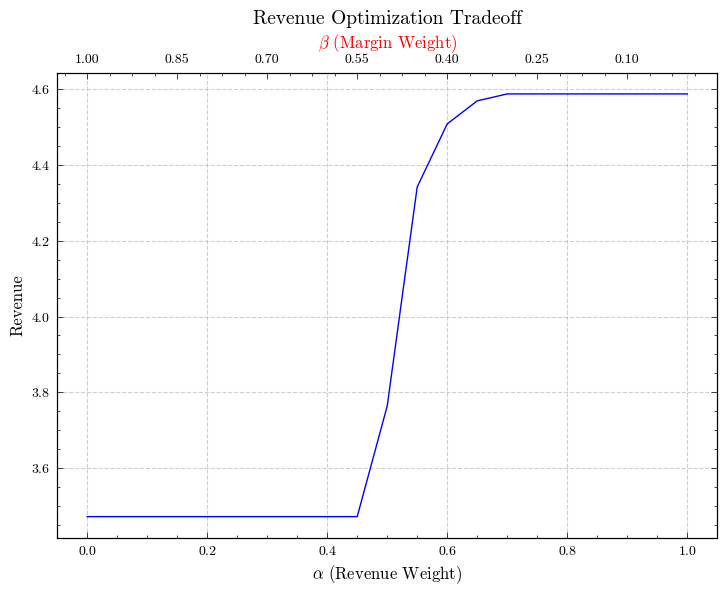

In [11]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Revenue vs Alpha
ax1.plot(alpha_values, revenues, linestyle='-', color='b', label="Revenue")
ax1.set_xlabel(r"$\alpha $ (Revenue Weight)", fontsize=12)
ax1.set_ylabel("Revenue", fontsize=12)
ax1.set_title("Revenue Optimization Tradeoff", fontsize=14)

ax2 = ax1.twiny() 
ax2.set_xlim(ax1.get_xlim()) 
ax2.set_xticks(alpha_values[::3])  
ax2.set_xticklabels([f"{b:.2f}" for b in beta_values[::3]], fontsize=10)
ax2.set_xlabel(r"$\beta $ (Margin Weight)", fontsize=12, color='red')


ax1.grid(True, linestyle="--", alpha=0.6) 
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

plt.show()

### Question 5: Hitting a margin goal while optimizing revenue <a id='5-2'></a> 

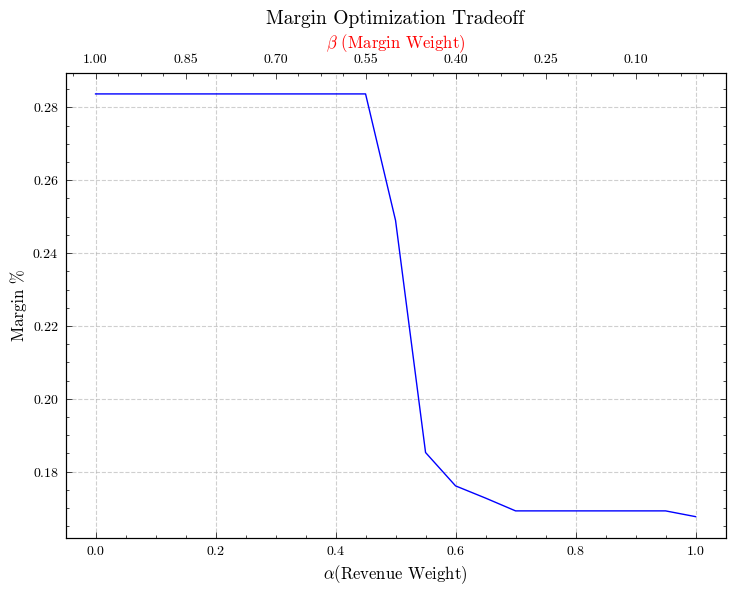

In [12]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Revenue vs Alpha
ax1.plot(alpha_values, margins, linestyle='-', color='b', label="Revenue")
ax1.set_xlabel(r"$\alpha $(Revenue Weight)", fontsize=12)
ax1.set_ylabel("Margin %", fontsize=12)
ax1.set_title("Margin Optimization Tradeoff", fontsize=14)


ax2 = ax1.twiny() 
ax2.set_xlim(ax1.get_xlim())  
ax2.set_xticks(alpha_values[::3])  
ax2.set_xticklabels([f"{b:.2f}" for b in beta_values[::3]], fontsize=10)
ax2.set_xlabel(r"$\beta $ (Margin Weight)", fontsize=12, color='red')

ax1.grid(True, linestyle="--", alpha=0.6) 
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

plt.show()


<a id='6'></a>
## 5 year forecasting with stochastic processes  

To simulate stochastic process we replicate a monte carlo simulation for each strategy to model the expected behavior over time

In [13]:
years = 5
results = run_all_simulations(strategies, years, None)

In [14]:
def plot_time_series(results, title=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Revenue
    ax = axes[0]
    for strategy in results:
        years = np.arange(1, len(strategy['revenue']) + 1)
        avg = np.array([np.mean(x) for x in strategy['revenue']])
        errors = np.array([np.std(x) for x in strategy['revenue']])
        ax.errorbar(years / 12, avg, yerr=errors, label=strategy['Name'], linestyle='-')

    ax.set_title('Revenue Forecast')
    ax.set_xlabel('Years')
    ax.set_ylabel('Total Revenue')
    ax.legend(title='Optimization Strategies')

    # Plot Profit
    ax = axes[1]
    for strategy in results:
        years = np.arange(1, len(strategy['margin']) + 1)
        avg = np.array([np.mean(x) for x in strategy['margin']])
        errors = np.array([np.std(x) for x in strategy['margin']])
        ax.errorbar(years / 12, avg, yerr=errors, label=strategy['Name'], linestyle='-')

    ax.set_title('Profit Forecast')
    ax.set_xlabel('Years')
    ax.set_ylabel('Profit')

    if title:
        fig.suptitle(title, fontweight='bold')

    plt.tight_layout()
    plt.show()


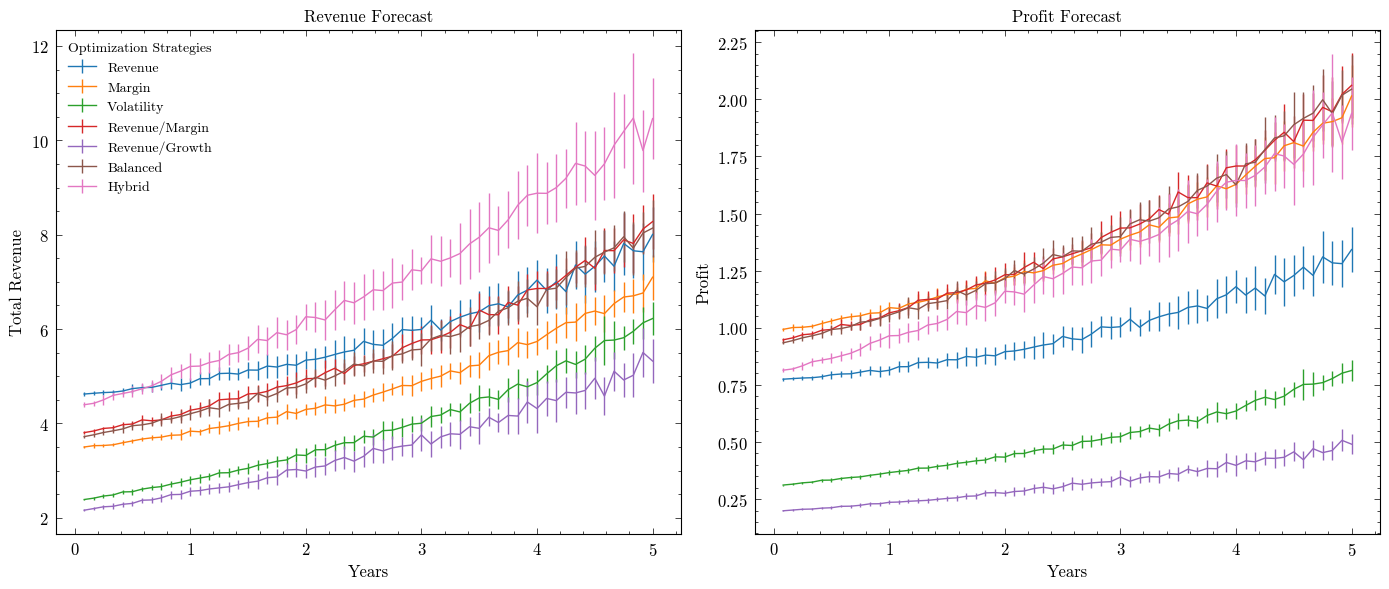

In [15]:
plot_time_series(results)

## Experimenting with different Macroeconomic Conditions <a class='anchor' id='7'></a> 

### Recession <a class='anchor' id='7-1'></a> 

In [24]:
years = 5
parameters = {
            'min_trend': -.15,
            'max_trend': -.3
              }
results = run_all_simulations(strategies, years, parameters)

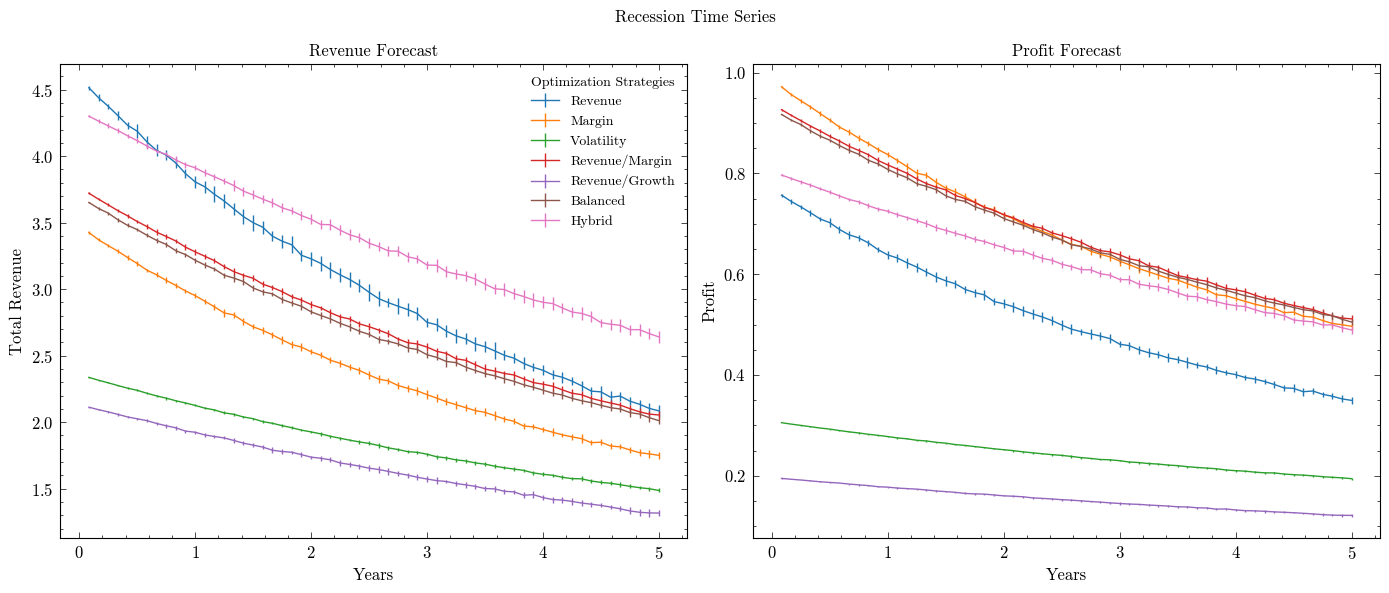

In [25]:
title = "Recession Time Series"
plot_time_series(results, title)

### High growth <a class='anchor' id='7-2'></a> 

In [18]:
years = 5
parameters = {
            'min_trend': .02,
            'max_trend': .15
              }
results = run_all_simulations(strategies, years, parameters)

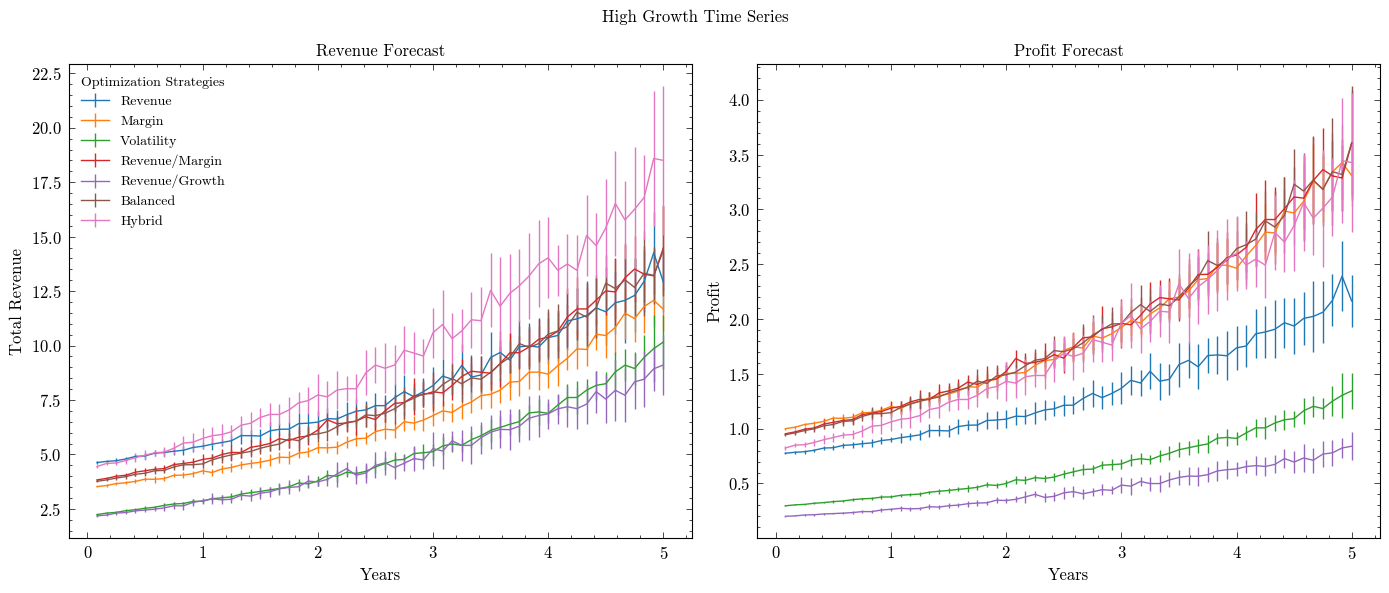

In [19]:
title = "High Growth Time Series"
plot_time_series(results, title)

Volatile

In [27]:
years = 5
parameters = {
            'min_trend': -.1,
            'max_trend': .1
              }
results = run_all_simulations(strategies, years, parameters)

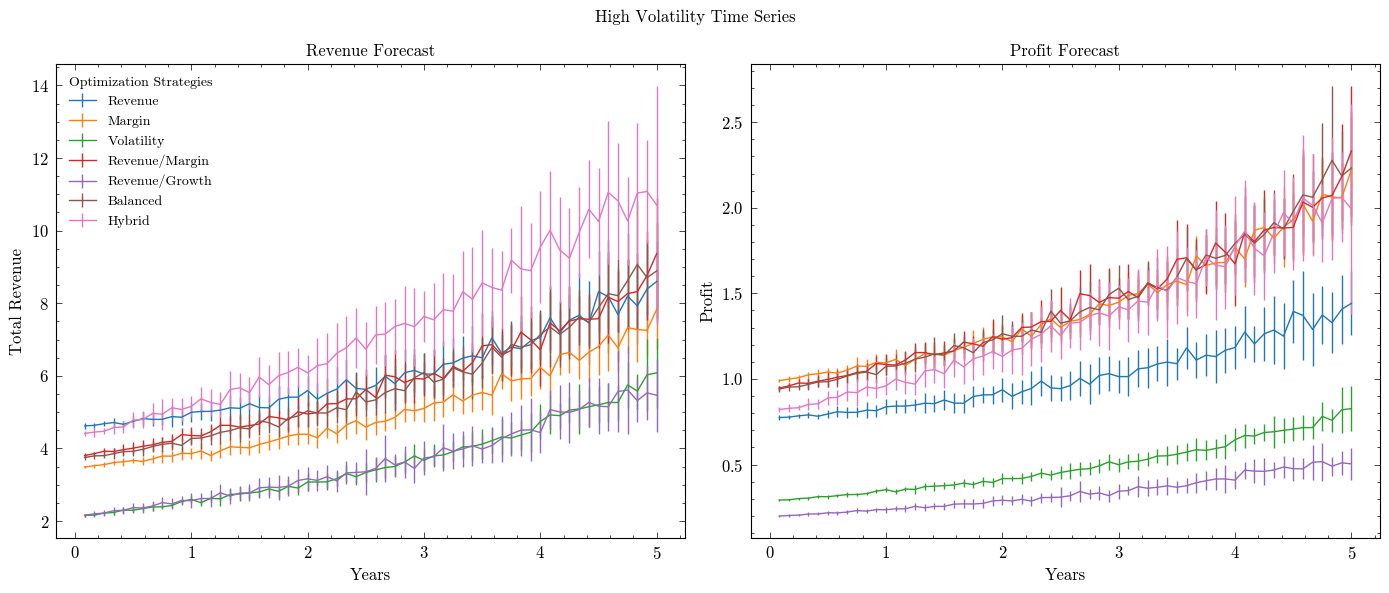

In [28]:
title = "High Volatility Time Series"
plot_time_series(results, title)

# Thoughts and Reflection <a id='8'></a>


Unfortunately, due to time constraints, I was unable to complete the optimization algorithm. However, the framework is in place. Although the approach is complex, using a tree-based representation allows for efficient trend simulation in specific areas while maintaining hierarchical dependencies.

This structure provides flexibility in modeling different scenarios and aggregating data across multiple levels. Given more time, I would refine the optimization process to ensure that the linear optimization worked correctly. Despite the limitations, this project has provided valuable insights into the difficulties in modeling complex real world data aswell as giving me practice in how to break down a vague question into a working model.